In [67]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *


DIM_Q = 2
DIM_RES = 10
A = destroy(DIM_RES)

K = 5.35 # MHz
X = 0.16*K # MHz
P1PH = 36.1 # MHz
PNORM = 4
MAX_AMP = np.sqrt(PNORM*P1PH) # MHz ?
WR = 7.062e3 # MHz
WQ = 5.092e3 # MHz
G = 102.9 # MHz

T_INITIAL = 0.0
T_FINAL = 4.0   # Try varying this
LENGTH = 400    # Try varying this
T_LIST = np.linspace(T_INITIAL, T_FINAL, LENGTH + 1)

H_JC = (
    WR * tensor(A.dag() * A, qeye(DIM_Q))
    + tensor(qeye(DIM_RES), WQ * sigmaz() / 2)
    + X * tensor(A.dag() * A, sigmaz())
    + X / 2 * tensor(qeye(DIM_RES), sigmaz())
)
#H_K = tensor(KERR*(A.dag()*A)**2, qeye(DIM_Q))
H_D1 = tensor(A.dag(), qeye(DIM_Q))
H_D2 = tensor(A, qeye(DIM_Q))

INITIAL_STATE = tensor(
    coherent(DIM_RES, np.sqrt(PNORM)), fock(2, 0)
)  # second input in coherent squared gives the init num of photons

NSTEPS = 10000

def H_D1A_coeff(t, args):
    return args['A0']*np.exp(-1j*args['WR']*t)

def H_D2A_coeff(t, args):
    return args['A0']*np.exp(1j*args['WR']*t)

def H_D1B_coeff(t, args):
    return args['A1']*np.exp(-1j*args['WR']*t)

def H_D2B_coeff(t, args):
    return args['A1']*np.exp(1j*args['WR']*t)

action = np.array([ -1, 1, -0.5, -0.5 ]) # amp 1, amp 2, time 1, time 2

first_time = int((action[2] + 1)*LENGTH/4)
second_time = int((action[3] + 1)*LENGTH/4)

if first_time == 0:
    first_time = 1
if second_time == 0:
    second_time = 1

HA = [H_JC, [H_D1, H_D1A_coeff], [H_D2, H_D2A_coeff]]
HB = [H_JC, [H_D1, H_D1B_coeff], [H_D2, H_D2B_coeff]]

args = {'A0': action[0]*MAX_AMP, 'A1': action[1]*MAX_AMP, 'WR': WR}

resultA = mesolve(HA, INITIAL_STATE, T_LIST[0:first_time], c_ops=[np.sqrt(K)*tensor(A, qeye(DIM_Q))], args=args, options=Options(nsteps=NSTEPS))

solutions = expect(tensor(A.dag()*A, qeye(DIM_Q)), resultA.states)

temp_state = tensor(
    coherent(DIM_RES, np.sqrt(solutions[-1])), fock(2, 0)
)  # second input in coherent squared gives the init num of photons

resultB = mesolve(HA, temp_state, T_LIST[first_time - 1: first_time + second_time], c_ops=[np.sqrt(K)*tensor(A, qeye(DIM_Q))], e_ops=[tensor(A.dag()*A, qeye(DIM_Q))], args=args, options=Options(nsteps=NSTEPS))

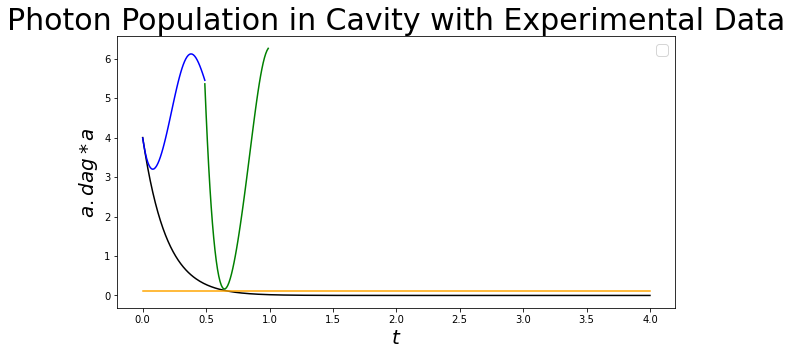

In [68]:
nat_decay = PNORM*np.exp(-K*T_LIST)
min_line = np.zeros_like(T_LIST) + 0.1

fig, axes = plt.subplots(figsize=(10, 5))
axes.plot(T_LIST, nat_decay, color="black")
axes.plot(resultA.times, solutions, color="blue")
axes.plot(resultB.times, resultB.expect[0], color="green")
axes.plot(T_LIST, min_line, color="orange")
axes.set_title(
    "Photon Population in Cavity with Experimental Data", fontsize=30
)
axes.set_xlabel(r"$t$", fontsize=20)
axes.set_ylabel(r"$a.dag*a$", fontsize=20)
axes.legend(fontsize=15)
plt.show()

In [69]:
resultA1 = mesolve(HA, INITIAL_STATE, T_LIST[0:first_time], c_ops=[np.sqrt(K)*tensor(A, qeye(DIM_Q))], args=args, options=Options(nsteps=NSTEPS))

results = expect(tensor(A.dag()*A, qeye(DIM_Q)), resultA1.states)

temp_state = resultA1.states[-1]

resultB1 = mesolve(HA, temp_state, T_LIST[first_time - 1: first_time + second_time], c_ops=[np.sqrt(K)*tensor(A, qeye(DIM_Q))], e_ops=[tensor(A.dag()*A, qeye(DIM_Q))], args=args, options=Options(nsteps=NSTEPS))

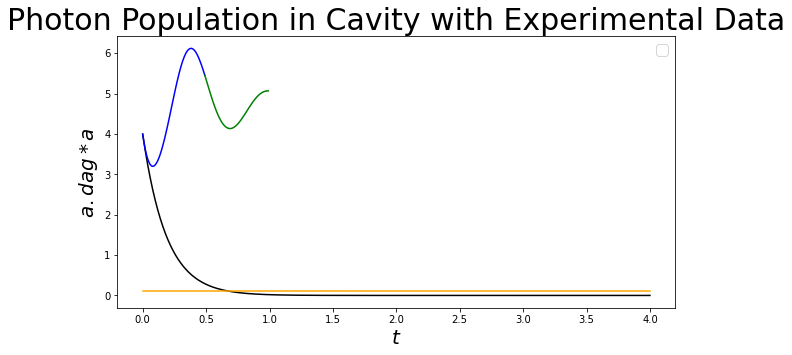

In [70]:
nat_decay = PNORM*np.exp(-K*T_LIST)
min_line = np.zeros_like(T_LIST) + 0.1

fig, axes = plt.subplots(figsize=(10, 5))
axes.plot(T_LIST, nat_decay, color="black")
axes.plot(resultA1.times, results, color="blue")
axes.plot(resultB1.times, resultB1.expect[0], color="green")
axes.plot(T_LIST, min_line, color="orange")
axes.set_title(
    "Photon Population in Cavity with Experimental Data", fontsize=30
)
axes.set_xlabel(r"$t$", fontsize=20)
axes.set_ylabel(r"$a.dag*a$", fontsize=20)
axes.legend(fontsize=15)
plt.show()

In [71]:
H_jc = X*tensor(A.dag()*A, sigmaz()) + X/2*tensor(qeye(DIM_RES), sigmaz())
H_d = tensor(A.dag(), qeye(DIM_Q)) + tensor(A, qeye(DIM_Q))

resultA2 = mesolve(H_jc + args['A0']*H_d, INITIAL_STATE, T_LIST[0:first_time], c_ops=[np.sqrt(K)*tensor(A, qeye(DIM_Q))], args=args, options=Options(nsteps=NSTEPS))

resulters = expect(tensor(A.dag()*A, qeye(DIM_Q)), resultA2.states)

tempe_state = resultA2.states[-1]

resultB2 = mesolve(H_jc + args['A1']*H_d, tempe_state, T_LIST[first_time - 1: first_time + second_time], c_ops=[np.sqrt(K)*tensor(A, qeye(DIM_Q))], e_ops=[tensor(A.dag()*A, qeye(DIM_Q))], args=args, options=Options(nsteps=NSTEPS))

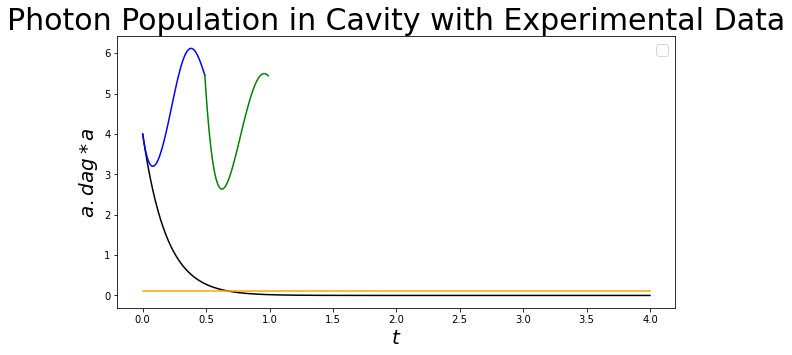

In [72]:
nat_decay = PNORM*np.exp(-K*T_LIST)
min_line = np.zeros_like(T_LIST) + 0.1

fig, axes = plt.subplots(figsize=(10, 5))
axes.plot(T_LIST, nat_decay, color="black")
axes.plot(resultA2.times, resulters, color="blue")
axes.plot(resultB2.times, resultB2.expect[0], color="green")
axes.plot(T_LIST, min_line, color="orange")
axes.set_title(
    "Photon Population in Cavity with Experimental Data", fontsize=30
)
axes.set_xlabel(r"$t$", fontsize=20)
axes.set_ylabel(r"$a.dag*a$", fontsize=20)
axes.legend(fontsize=15)
plt.show()

In [73]:
resultA3 = mesolve(H_jc + args['A0']*H_d, INITIAL_STATE, np.array([0, T_LIST[first_time - 1]]), c_ops=[np.sqrt(K)*tensor(A, qeye(DIM_Q))], args=args, options=Options(nsteps=NSTEPS))

temper_state = resultA3.states[-1]

resultB3 = mesolve(H_jc + args['A1']*H_d, temper_state, T_LIST[first_time - 1: first_time + second_time], c_ops=[np.sqrt(K)*tensor(A, qeye(DIM_Q))], e_ops=[tensor(A.dag()*A, qeye(DIM_Q))], args=args, options=Options(nsteps=NSTEPS))

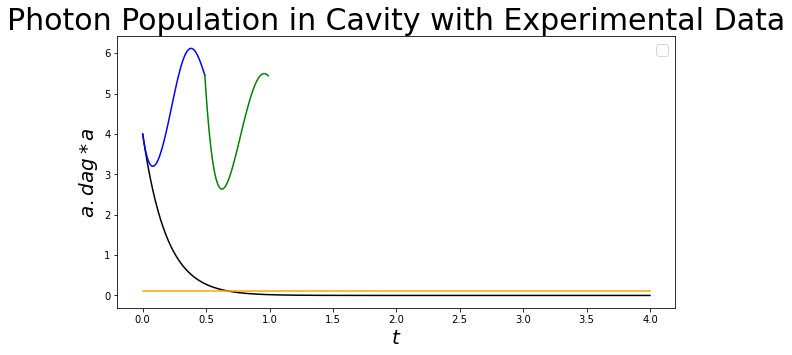

In [74]:
nat_decay = PNORM*np.exp(-K*T_LIST)
min_line = np.zeros_like(T_LIST) + 0.1

fig, axes = plt.subplots(figsize=(10, 5))
axes.plot(T_LIST, nat_decay, color="black")
axes.plot(resultA2.times, resulters, color="blue")
axes.plot(resultB3.times, resultB3.expect[0], color="green")
axes.plot(T_LIST, min_line, color="orange")
axes.set_title(
    "Photon Population in Cavity with Experimental Data", fontsize=30
)
axes.set_xlabel(r"$t$", fontsize=20)
axes.set_ylabel(r"$a.dag*a$", fontsize=20)
axes.legend(fontsize=15)
plt.show()